# GAN for dataset
This notebook is for using Gan and then TSTR fitting data using Random forest classifier, ROC

In [153]:
!pip install catboost
!pip install ctgan

Defaulting to user installation because normal site-packages is not writeable


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: C:\Users\isund\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: C:\Users\isund\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [154]:
from ctgan import CTGAN
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier


import numpy as np
import pandas as pd

In [155]:
#Load and prepare data
df = pd.read_parquet("NIDS_DF_processed.parquet")
df.drop(columns=['Attack_int'], inplace=True)
#df_small = df.sample(20000, random_state=42)
k = 870  # max rows per attack type

small_df = (
    df
    .groupby("Attack", group_keys=False)
    .apply(lambda g: g.sample(
        n=min(len(g), k),
        random_state=42
    ))
)

print("Total rows:", len(small_df))
print(small_df["Attack"].value_counts())

Total rows: 16686
Attack
Backdoor          870
Bot               870
Benign            870
Brute Force       870
DDoS              870
Theft             870
DoS               870
Exploits          870
Fuzzers           870
Generic           870
Infilteration     870
Reconnaissance    870
Shellcode         870
xss               870
injection         870
mitm              870
password          870
scanning          870
Analysis          731
Worms             153
ransomware        142
Name: count, dtype: int64


C:\Users\isund\AppData\Local\Temp\ipykernel_27032\646861218.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(


training data, training labels, testing samples and testing_labels

In [ ]:
training_data, test_data = train_test_split(small_df, test_size = 0.25)

#Label is a 0 for begnin and 1 for attack, there is also attack_int and attack_str
training_samples = training_data.drop(columns='Label')
training_labels = training_data['Label']

test_samples = test_data.drop(columns='Label')
test_labels = test_data['Label']

In [139]:
test_data['Label'].value_counts()

Label
0    3915
1    1085
Name: count, dtype: int64

In [140]:
df_small['Label'].value_counts()
df_small.head()

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack
6629671,53159,3389,6,0.000000,1600,1873,11,7,30,4290877,0,Benign
8088142,80,40562,6,0.000000,31226,0,129,0,27,0,0,Benign
5650419,49783,443,6,91.178001,1592,726,8,8,27,4289914,0,Benign
1656439,57626,80,6,7.000000,538,696,5,4,27,227,1,scanning
1271261,60379,111,17,0.000000,568,320,4,4,0,0,0,Benign


# GAN

In [141]:
# Train CTGAN
ctgan = CTGAN(
    epochs=30,
    verbose=True
)
#editted for minority class being 

                        

In [142]:
# Specify discrete (categorical) columns so CTGAN won't try to convert them to numeric
# Training data uses 'Attack' (string) and 'Attack_int' (category codes) as discrete columns
ctgan.fit(
	training_data.query('Label==1').drop(columns=('Label')),
	discrete_columns=['Attack']
)

Gen. (0.64) | Discrim. (0.11): 100%|██████████| 30/30 [00:16<00:00,  1.83it/s] 


In [143]:
# categorical_cols = ["Attack", "Label"] # Later we can select only one or the other for comparison like isabella said

# Generate and clean synthetic data
synthetic_df = ctgan.sample(500000)
synthetic_df.insert(len(synthetic_df.columns),'Label',1)



In [144]:
# Preview rows
print(synthetic_df.head())
print("\n#--------------------------------------------------#")

# Compare class distribution
# use the original 'Label' column from the real dataframe (df_small is the sampled dataset used for training)
real_attack_ctns = df_small['Label'].value_counts(normalize=True)
synthetic_attack_ctns = synthetic_df['Label'].value_counts(normalize=True)

comparison = pd.concat([real_attack_ctns, synthetic_attack_ctns], axis=1)
comparison.columns = ["Real Dist", "Synthetic Dist"]

print(comparison)
print("#--------------------------------------------------#\n")

# Summary statistics for synthetic data
print(synthetic_df.describe())

   L4_SRC_PORT  L4_DST_PORT  PROTOCOL  L7_PROTO  IN_BYTES  OUT_BYTES  IN_PKTS  \
0        36946          148         6 -1.772932      2073       -314      -62   
1        56729         -146         6  4.999145      4355        505      -13   
2        49769          135         6  5.724980      1302        357     -128   
3        67231          106         6 -1.596378      5692        533       38   
4        44463         -379         6 -1.327267      4183        342      -58   

   OUT_PKTS  TCP_FLAGS  FLOW_DURATION_MILLISECONDS         Attack  Label  
0         3          0                       79619      injection      1  
1         3         27                     3961887  Infilteration      1  
2         8         26                       72700            Bot      1  
3         0         23                      -22810      injection      1  
4         0         29                      -15736           DDoS      1  

#--------------------------------------------------#
       Re

In [145]:
train_synthetic = pd.concat([training_data, synthetic_df], ignore_index=True)

In [146]:
train_synthetic['Attack'].value_counts()
train_synthetic['Label'].value_counts()

Label
1    503215
0     11785
Name: count, dtype: int64

In [147]:
# Prepare training data from synthetic+real mix
X = train_synthetic.drop(columns='Label')
y = train_synthetic['Label'].astype(int)

# Tell CatBoost which column is categorical
cat_features = ['Attack']

# Train CatBoost on the synthetic-augmented training set and evaluate on the test set
clf = CatBoostClassifier(
    iterations=300,
    depth=8,
    learning_rate=0.1,
    loss_function='Logloss',
    verbose=50,
    random_state=42
)

clf.fit(X, y, cat_features=cat_features, eval_set=(test_samples, test_labels))

# Evaluate
probs = clf.predict_proba(test_samples)[:, 1]
preds = (probs >= 0.5).astype(int)

print("AUC:", roc_auc_score(test_labels, probs))
print("Accuracy:", accuracy_score(test_labels, preds))

0:	learn: 0.3162114	test: 0.3731320	best: 0.3731320 (0)	total: 552ms	remaining: 2m 45s
50:	learn: 0.0000835	test: 0.0009131	best: 0.0009131 (33)	total: 21.4s	remaining: 1m 44s
100:	learn: 0.0000835	test: 0.0009130	best: 0.0009130 (92)	total: 40.2s	remaining: 1m 19s
150:	learn: 0.0000835	test: 0.0009130	best: 0.0009130 (117)	total: 58.7s	remaining: 57.9s
200:	learn: 0.0000835	test: 0.0009130	best: 0.0009130 (117)	total: 1m 15s	remaining: 37.2s
250:	learn: 0.0000834	test: 0.0009129	best: 0.0009129 (212)	total: 1m 31s	remaining: 17.9s
299:	learn: 0.0000834	test: 0.0009129	best: 0.0009129 (212)	total: 1m 45s	remaining: 0us

bestTest = 0.0009129092779
bestIteration = 212

Shrink model to first 213 iterations.
AUC: 1.0
Accuracy: 1.0


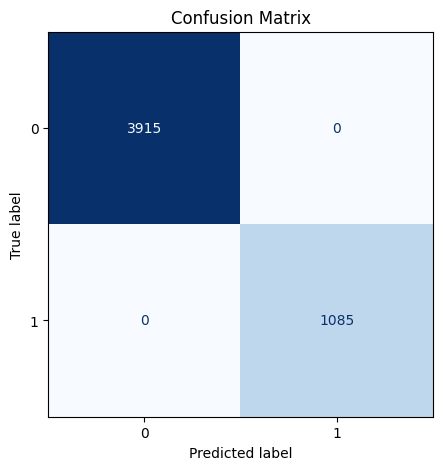

In [148]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

# preds and test_labels are already defined in the notebook
cm = confusion_matrix(test_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
ax.set_title("Confusion Matrix")
plt.show()

In [151]:
!pip install seaborn


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: C:\Users\isund\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


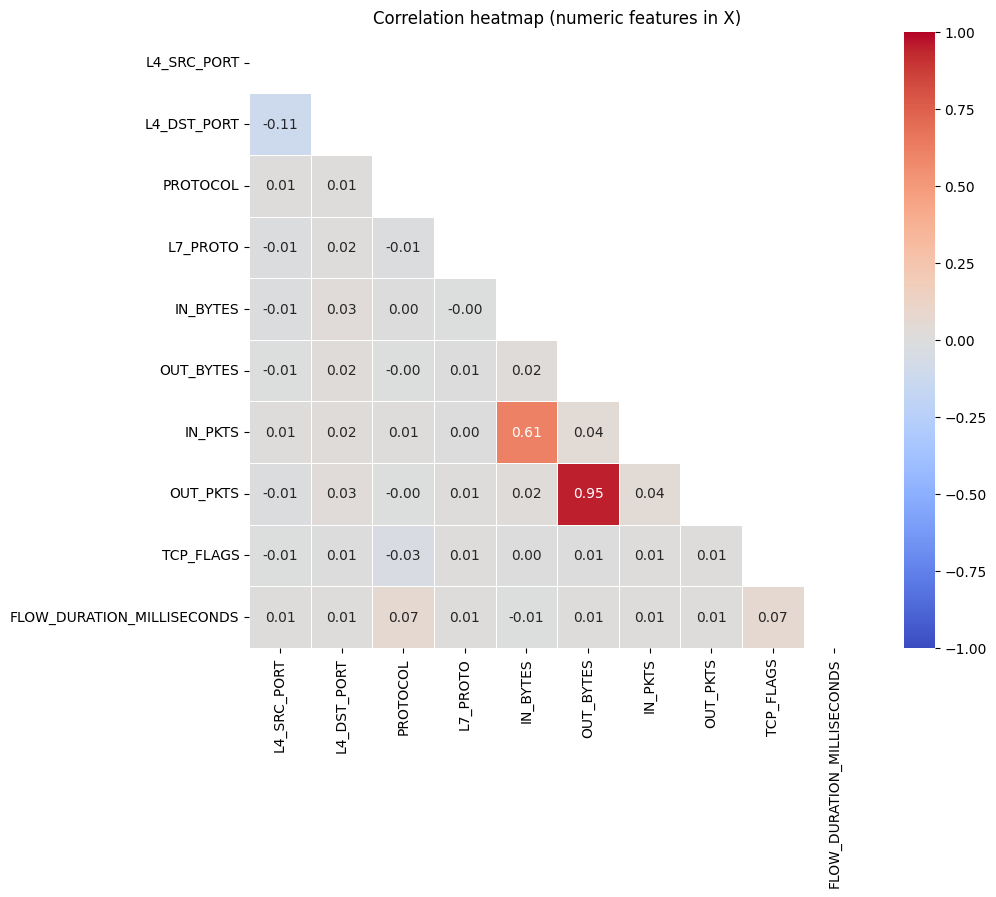

In [152]:
import seaborn as sns

# select numeric columns from X and compute correlation
num_df = X.select_dtypes(include=[np.number])
corr = num_df.corr()

# mask upper triangle for clarity
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, square=True, linewidths=.5, ax=ax)
ax.set_title("Correlation heatmap (numeric features in X)")
plt.show()